# Detección de Idiomas - LSTM

### Importar librerías

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Cargar el dataset

In [2]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,20821,20821
unique,20821,21
top,aprilie sonda spațială messenger a nasa și-a ...,Thai
freq,1,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [3]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=100)
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  304,  254, 1268,   61,  304, 9214,
        313,  204, 5593,   61, 7428, 2132,   86, 3594, 7428, 2132,   86,
       3594], dtype=int32)

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [4]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 16, 18, 17,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (14574, 100) (14574,)
Validación: (2082, 100) (2082,)
Prueba: (4165, 100) (4165,)


### Construcción del Modelo LSTM

Aquí creamos la arquitectura del modelo con una capa de Embedding, seguida de una capa LSTM y capas densas para la clasificación.

In [9]:
model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=100))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Compilar el Modelo

Ahora compilamos el modelo usando una función de pérdida adecuada (entropía cruzada) y un optimizador (Adam).

In [10]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

### Entrenar el Modelo

In [11]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.4350 - loss: 2.0341 - val_accuracy: 0.9654 - val_loss: 0.1482
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9631 - loss: 0.1382 - val_accuracy: 0.9712 - val_loss: 0.1087
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.9750 - loss: 0.0796 - val_accuracy: 0.9745 - val_loss: 0.1001
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 84s 189ms/step - accuracy: 0.9814 - loss: 0.0642 - val_accuracy: 0.9745 - val_loss: 0.0946
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.9838 - loss: 0.0565 - val_accuracy: 0.9765 - val_loss: 0.0885
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.9834 - loss: 0.0504 - val_accuracy: 0.9769 - val_loss: 0.0919
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - accuracy: 0.9839 - loss: 0.0479 - val_accuracy: 0.9779 - val_loss: 0.0885
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - accuracy: 0.9831 - loss: 0

### Evaluación del Modelo

In [12]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9752 - loss: 0.0897
Accuracy: 97.43%


### Guardar el modelo

In [13]:
model.save("models/lstm_model.keras")

### Ejemplos de Predicciones

In [14]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

for i in range(5):
    predicted_language = language_names[y_pred[i]]
    real_language = language_names[y_test[i]]

    print(f"Texto: {decoded_texts[i]}")
    print(f"Predicción: {predicted_language} (Real: {real_language})\n")

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Texto: ने दो या दो से अधिक पदक जिसमें ने तीन पदक में की ने तीन पदक थे जबकि फ्रांस के ने दो और एक पदक थे। महिला विश्व ने प्रत्येक रंग का पदक जबकि टीम के ने अपने पहले में एक और दो पदक ने दो और एक पदक
Predicción: Hindi (Real: Hindi)

Texto: اکتوبر سال کا ہے۔ رومی تقویم میں یہ ہوتا تھا اسے اکتوبر کہا جاتا تھا یونانی زبان میں کو کہا جاتا ہے۔ شمالی نصف میں اس کا موسم ہوتا ہے
Predicción: Urdu (Real: Urdu)

Texto: พศ ๆ เช่น อังกฤษ เล่ม คือ de des arts et des
Predicción: Thai (Real: Thai)

Texto: merupakan anak pertama dari empat juga anak pertama adalah seorang juga ahli dan tradisional waktu terutama untuk yang dan anak anak tidak jumlah anak anak dan yang pernah
Predicción: Indonesian (Real: Indonesian)

Texto: a fost descoperit în de către într o din în de sus a fost la paris în par les de la mission française au t ix se află la și s a că a fost între al viii lea și al xii lea până la despre apocalipsa lui petru se din
Predicción: Romanian (Real: Ro

In [21]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       199
           1       1.00      0.99      1.00       199
           2       0.96      0.99      0.98       200
           3       0.97      0.97      0.97       200
           4       0.99      0.99      0.99       198
           5       1.00      0.99      1.00       197
           6       0.99      0.97      0.98       194
           7       0.72      0.95      0.82       200
           8       0.99      0.98      0.99       200
           9       0.98      0.98      0.98       190
          10       1.00      1.00      1.00       200
          11       0.99      1.00      0.99       199
          12       0.99      1.00      0.99       197
          13       0.99      0.99      0.99       200
          14       0.99      0.99      0.99       200
          15       0.99      0.99      0.99       199
          16       0.99      1.00      1.00       197
  

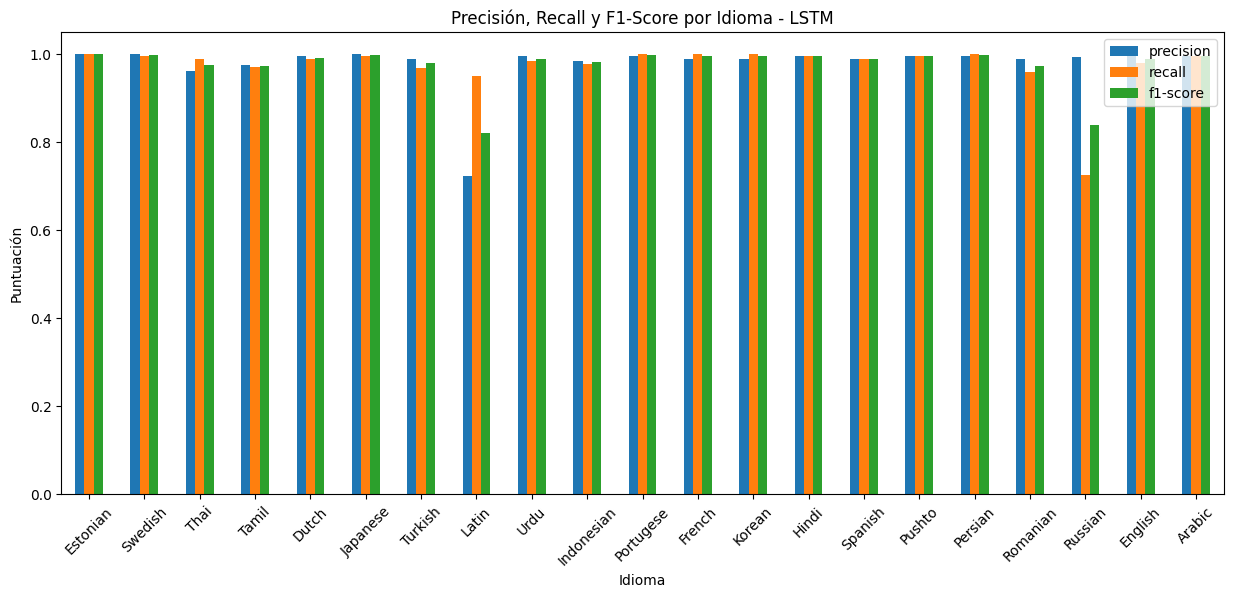

In [22]:
language_names = df['Language'].unique()
report_dict = classification_report(y_test, y_pred, target_names=language_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Precisión, Recall y F1-Score por Idioma - LSTM")
plt.ylabel("Puntuación")
plt.xlabel("Idioma")
plt.xticks(rotation=45)
plt.savefig("plots/lstm_precision_recall_f1.png")
plt.show()

In [15]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Texto: hola este es un texto en español
Predicción: Spanish

Texto: hello this is a text in english
Predicción: English

Texto: bonjour ceci est un texte en français
Predicción: Japanese

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

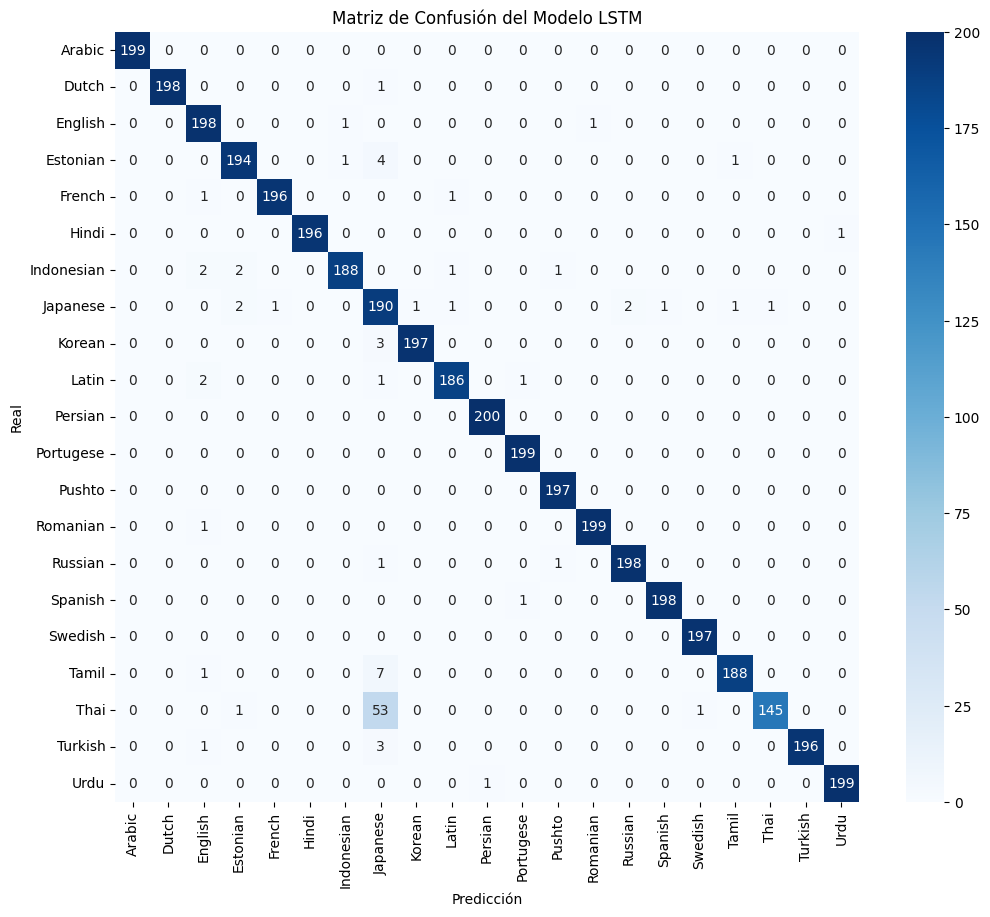

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/lstm_confusion_matrix.png")
plt.show()

### Matriz de Confusión Normalizada

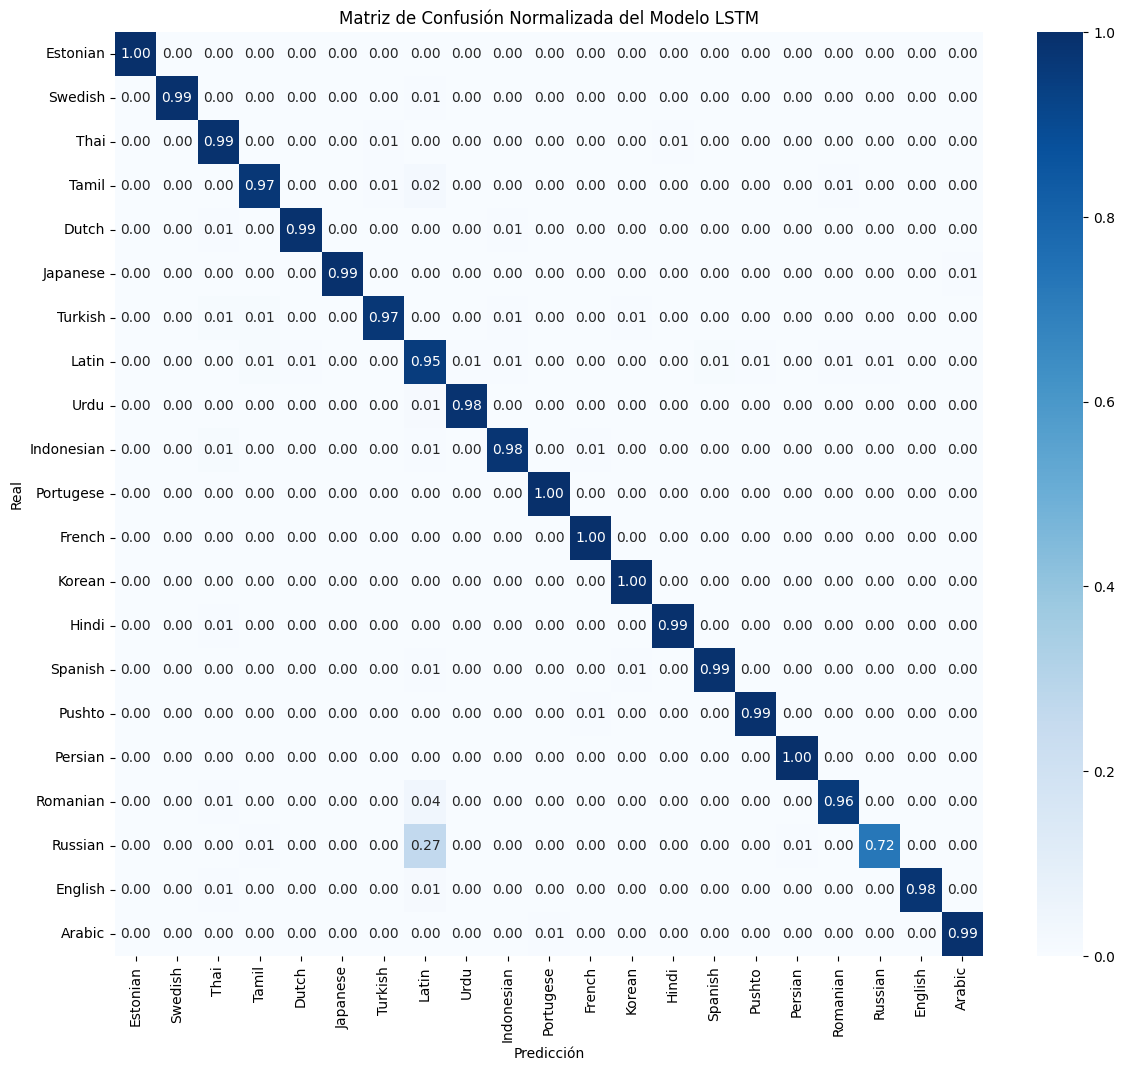

In [17]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=df['Language'].unique(), yticklabels=df['Language'].unique())
plt.title("Matriz de Confusión Normalizada del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("plots/lstm_confusion_matrix_normalized.png")
plt.show()

### Accuracy en Train y Validation

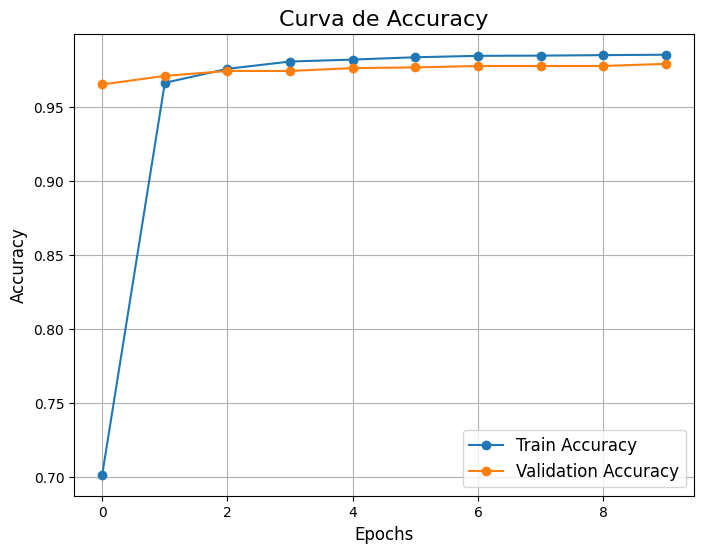

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_accuracy_curve.png")
plt.show()

### Loss en Train y Validation

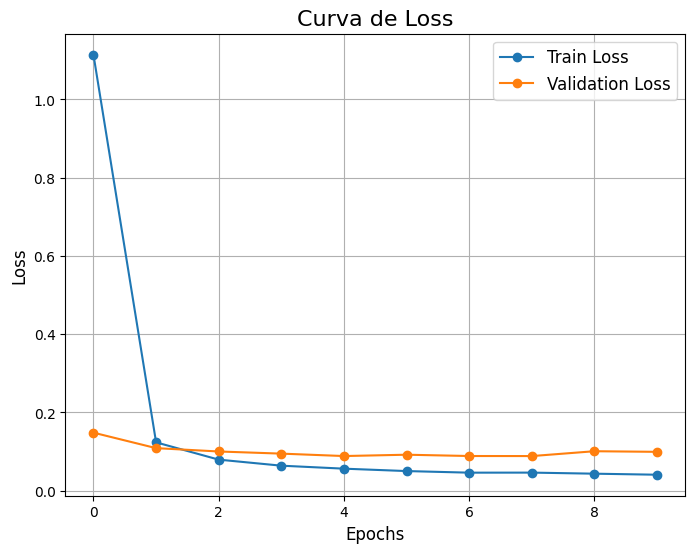

In [19]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_loss_curve.png")
plt.show()